# Assignment

## Instructions

In this assignment, you will apply time series forecasting techniques to analyze and predict future values. You will work with the "Global Temperature Time Series" dataset, which contains monthly temperature anomalies from 1880 to present day.

### Task: Global Temperature Forecasting

Your task is to analyze the global temperature time series and build forecasting models to predict future temperature trends. Follow these steps:

1. **Data Exploration**

   - Load and prepare the dataset
   - Visualize the time series data
   - Check for trends, seasonality, and cycles
   - Create seasonal plots and subseries plots
   - Analyze autocorrelation using ACF plots

2. **Time Series Decomposition**

   - Decompose the time series into trend, seasonal, and residual components
   - Compare additive and multiplicative decomposition methods
   - Interpret your findings

3. **Forecasting**

   - Split the data into training and testing sets using a temporal split
   - Implement and evaluate the following forecasting methods:
     - Naive forecasting (last value and seasonal naive)
     - ARIMA/SARIMA models
     - Exponential smoothing models
   - Use appropriate evaluation metrics (MAE, MAPE, sMAPE) to compare model performance

4. **Model Selection and Interpretation**
   - Determine which model performs best for this dataset
   - Interpret the results and explain why certain models might work better than others
   - Generate forecasts for future periods

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# Load the dataset (NASA GISTEMP Global Temperature Anomaly)
url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"

In [5]:
# Data preparation
def prepare_nasa_data(url):
    # Read the data, skipping the header explanation
    df = pd.read_csv(url, skiprows=1)

    # Remove the unnecessary columns
    df = df.iloc[:, :13]

    # Rename columns
    df.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Convert from wide to long format
    df_long = df.melt(id_vars=['Year'],
                       var_name='Month',
                       value_name='Temperature_Anomaly')

    # Filter out missing or invalid data
    df_long = df_long[df_long['Temperature_Anomaly'] != '***']
    df_long['Temperature_Anomaly'] = df_long['Temperature_Anomaly'].astype(float)

    # Create a proper date index
    df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'], format='%Y-%b')

    # Sort by date
    df_long = df_long.sort_values('Date')

    # Create a time series
    ts_data = df_long.set_index('Date')['Temperature_Anomaly']

    return ts_data

# Prepare the time series data
ts_data = prepare_nasa_data(url)

# Now you have a time series object 'ts_data' to work with
print(f"Time series data from {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Total number of observations: {len(ts_data)}")

Time series data from 1880-01-01 00:00:00 to 2025-12-01 00:00:00
Total number of observations: 1752


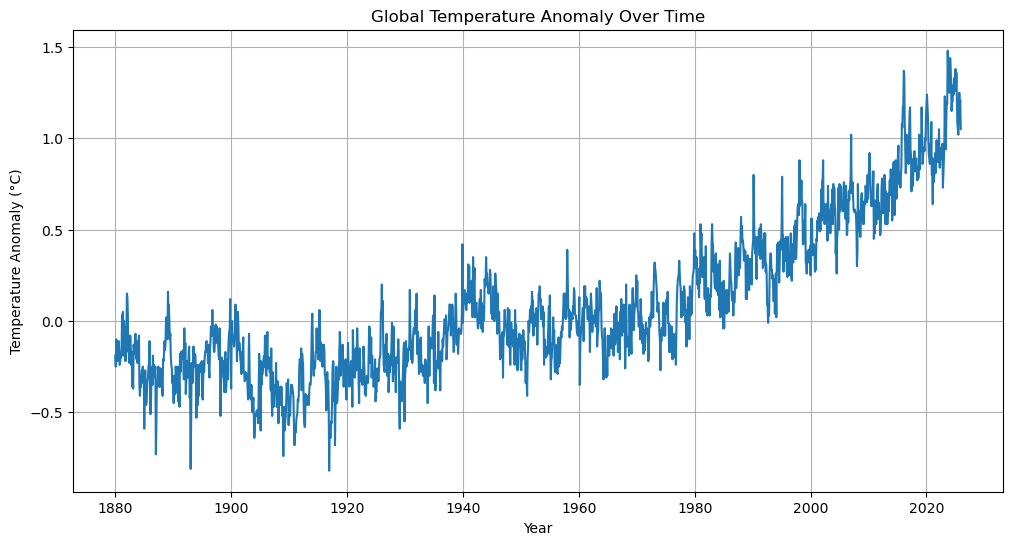

In [6]:
## Explore and visualize the time series data
# 1. Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data.values)
plt.title('Global Temperature Anomaly Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.grid(True)
plt.show()

Long-term trend
- From 1880 to 2025, the global temperature anomaly shows a strong, persistent upward trend.
- Early period (1880–1940): mostly negative anomalies
- Mid-century (1940–1970): relatively flat / slight cooling
- Post-1970: accelerating warming, especially after 1990
- Recent years: anomalies consistently above +1.0°C

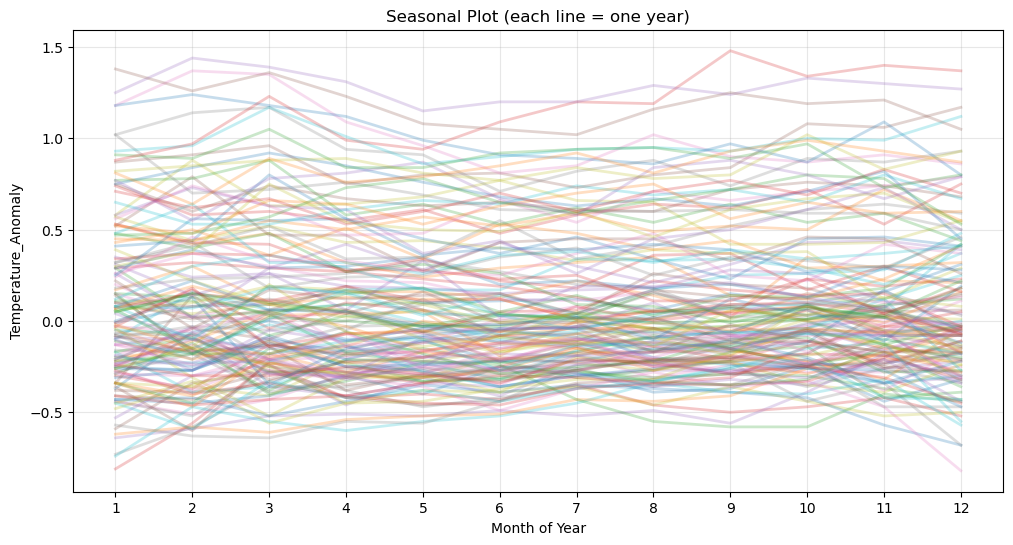

In [7]:
#2. Seasonal plot
years = ts_data.index.year.unique()

plt.figure(figsize=(12, 6))
for year in years:
    y = ts_data[ts_data.index.year == year]
    plt.plot(y.index.month, y.values, alpha=0.25, linewidth=2)

plt.title("Seasonal Plot (each line = one year)")
plt.xlabel("Month of Year")
plt.ylabel(ts_data.name)
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.show()


The seasonal plot indicates weak seasonality in the global temperature anomaly series. Unlike classical seasonal datasets such as retail sales or airline passengers, temperature anomalies do not exhibit consistent repeating monthly patterns across years. The overlapping lines and lack of a stable seasonal shape suggest that the dominant structure of the series is the long-term trend rather than seasonal variation.

Autocorrelations: [1.         0.95602199 0.94117422 0.92704047 0.91926381 0.9101857
 0.90360238 0.89677987 0.89160994 0.88520181 0.87913435 0.87449264
 0.87066947 0.86321767 0.85535688 0.84559796 0.84187651 0.83770325
 0.83409778 0.83198031 0.82899731 0.82849224 0.82626235 0.82430609
 0.82577149 0.81678668 0.81058801 0.804175   0.80012846 0.79616443
 0.79282109 0.79074569 0.79091524 0.79325077 0.7920991  0.7938151
 0.79255457 0.79037319 0.78919305 0.78359061 0.78368196 0.78347058
 0.7820732  0.78123187 0.78119566 0.78052718 0.77691872 0.77586354
 0.77854466 0.77585966 0.77304866 0.76822687 0.76368278 0.76117304
 0.75806623 0.75621464 0.75555856 0.75423595 0.75220229 0.75170382
 0.74824598]


<Figure size 1200x600 with 0 Axes>

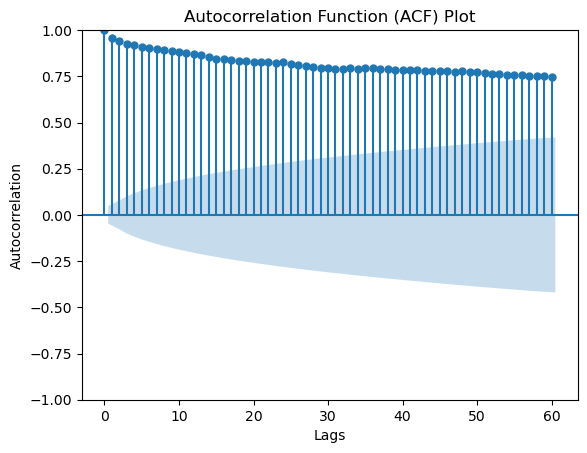

In [8]:
# 3. Autocorrelation plots
from pmdarima import acf

autocorrelations = acf(ts_data, nlags=60)

print(f'Autocorrelations: {autocorrelations}')
plt.figure(figsize=(12, 6))
plot_acf(ts_data, lags=60, alpha=0.05)
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Autocorrelation looks at how similar the series is to itself if shifting back in time.
    - Lag 1 → compare this month with last month
    - Lag 12 → compare this month with same month last year
    - Lag 60 → compare this month with 5 years ago
    - Shaded region: Confidence band. If a bar is outside it → correlation is statistically significant

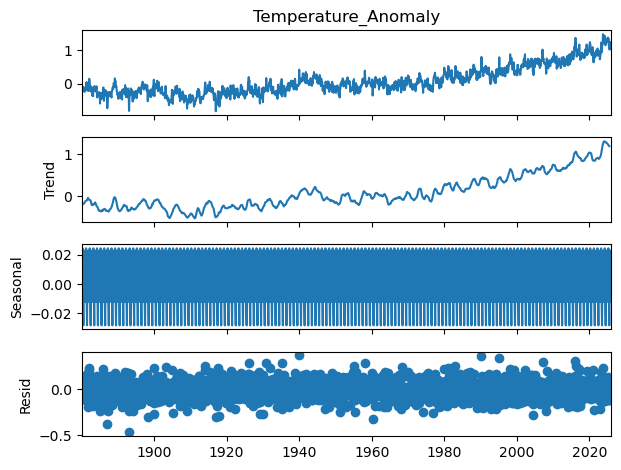

In [9]:
## Perform time series decomposition
# Additive decomposition
ts_data.index = dates = pd.date_range(start='1880-01-01', periods=len(ts_data), freq='M')   
decomposition = seasonal_decompose(ts_data, model='additive')
decomposition.plot()
plt.show()

Additive time series decomposition reveals that the global temperature anomaly series is dominated by a strong long-term trend, reflecting sustained global warming over time. The seasonal component exhibits very low amplitude relative to the trend, indicating weak monthly seasonality. The residual component appears largely random, suggesting that most systematic variation in the series is captured by the trend.

In [10]:
# Multiplicative decomposition
# decomposition_mult = seasonal_decompose(ts_data, model='multiplicative')
# decomposition_mult.plot()
# plt.show()

Multiplicative decomposition could not be applied directly because the temperature anomaly series contains zero and negative values. This method assumes strictly positive data (trend and seasonality interact proportionally). Since anomalies are additive deviations around a baseline, additive decomposition is more conceptually appropriate for this dataset.

In [11]:
# Split the data into training and testing sets
y_train, y_test = temporal_train_test_split(ts_data, test_size=120)  # Last 10 years for testing
print(f'Training set length: {len(y_train)}')
print(f'Testing set length: {len(y_test)}')


Training set length: 1632
Testing set length: 120


In [12]:
# Initialize the naive forecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

NaiveForecaster()

In [13]:
# Define the forecasting horizon
fh = np.arange(1, len(y_test) + 1)

In [14]:
y_pred = forecaster.predict(fh=fh)

sMAPE (Naive): 0.204


/home/ninahoang/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ninahoang/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ninahoang/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ninahoang/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

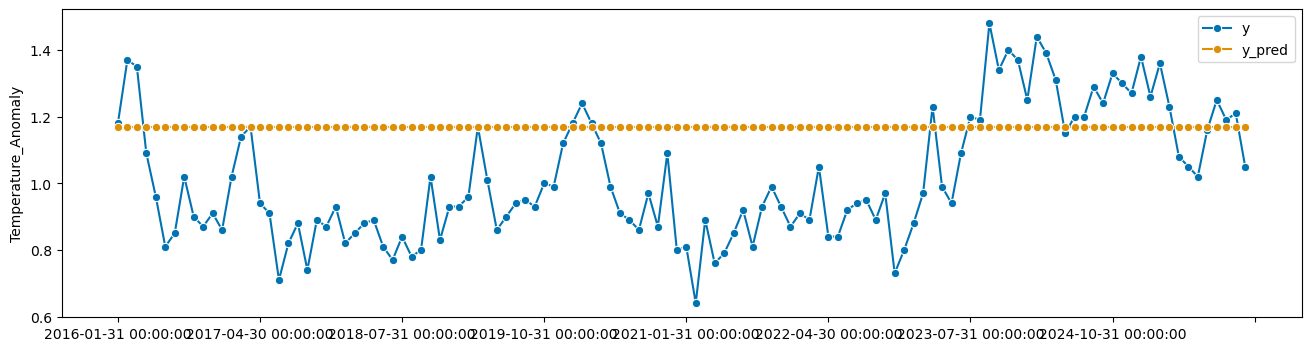

In [15]:
# plotting predictions and past data
plot_series(y_test, y_pred, labels=["y", "y_pred"])
smape_naive = mean_absolute_percentage_error(y_test, y_pred, symmetric=True)
print(f'sMAPE (Naive): {smape_naive:.3f}')

The naive forecasting model produces a flat forecast equal to the last observed value in the training set. While this approach provides a simple baseline, it fails to capture the continued upward trend in temperature anomalies during the test period, leading to increasing underestimation in later years. This highlights the need for trend-aware models such as ARIMA or exponential smoothing.

ARIMA = AutoRegressive + Integrated + Moving Average

In [16]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

In [17]:
# Initialize the AutoARIMA model
auto_arima_model = AutoARIMA(
    seasonal=False,
    suppress_warnings=True,
    stepwise=True
)

In [18]:
# Fit the model
auto_arima_model.fit(y_train)

AutoARIMA(seasonal=False, suppress_warnings=True)

In [19]:
auto_arima_model.get_fitted_params()

{'intercept': 9.359165722518318e-05,
 'ar.L1': 0.8412176132822149,
 'ma.L1': -1.3457106755748487,
 'ma.L2': 0.36203160147531116,
 'sigma2': 0.011607406500276241,
 'order': (1, 1, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': -2628.1274634609,
 'aicc': -2628.090540383977,
 'bic': -2601.142720447795,
 'hqic': -2618.116787819171}

In [20]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1632
Model:               SARIMAX(1, 1, 2)   Log Likelihood                1319.064
Date:                Fri, 23 Jan 2026   AIC                          -2628.127
Time:                        11:21:12   BIC                          -2601.143
Sample:                    01-31-1880   HQIC                         -2618.117
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.359e-05   4.79e-05      1.952      0.051   -3.72e-07       0.000
ar.L1          0.8412      0.027     30.602      0.000       0.787       0.895
ma.L1         -1.3457      0.038    -35.430      0.000      -1.420      -1.271
ma.L2          0.3620      0.035     10.373      0.000       0.294       0.430
sigma2         0.0116      0.000     34.357      0.000       0.011       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                67.30
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.12
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
y_pred_auto_arima = auto_arima_model.predict(fh=fh)

In [22]:
# Calculate sMAPE for each model
smape_auto_arima = mean_absolute_percentage_error(y_test, y_pred_auto_arima, symmetric=True)
print(f'sMAPE (AutoARIMA): {smape_auto_arima:.3f}')

sMAPE (AutoARIMA): 0.179


AutoETS refers to the automated selection and fitting of an Exponential Smoothing State Space Model (ETS). It is designed to identify the most appropriate error, trend, and seasonality (ETS) components of a time series without manual intervention.

In [23]:
from sktime.forecasting.ets import AutoETS

In [24]:
auto_ets_model = AutoETS(
    auto=True,
    sp=12,
    seasonal=None,
    trend="add",
    error="add",
    n_jobs=1
)
auto_ets_model.fit(y_train)

/tmp/ipykernel_1122/731999191.py:1: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns with the automatic model selection.
  auto_ets_model = AutoETS(
/home/ninahoang/miniconda3/envs/ml/lib/python3.11/site-packages/skbase/base/_base.py:139: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns with the automatic model selection.
  self.__init__(**params)
/home/ninahoang/miniconda3/envs/ml/lib/python3.11/site-packages/sktime/forec

AutoETS(auto=True, n_jobs=1, sp=12, trend='add')

In [25]:
auto_ets_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ETS Results                                  
===============================================================================
Dep. Variable:     Temperature_Anomaly   No. Observations:                 1632
Model:                        ETS(ANA)   Log Likelihood                1300.772
Date:                 Fri, 23 Jan 2026   AIC                          -2569.543
Time:                         11:21:47   BIC                          -2483.183
Sample:                     01-31-1880   HQIC                         -2537.507
                          - 12-31-2015   Scale                            0.012
Covariance Type:                approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4885      0.026     19.039      0.000       0.438       0.539
smoothing_seasonal   5.115e-05        nan        nan        nan         nan         nan
initial_level          -0.1920        nan        nan        nan         nan         nan
initial_seasonal.0     -0.0111        nan        nan        nan         nan         nan
initial_seasonal.1      0.0166        nan        nan        nan         nan         nan
initial_seasonal.2      0.0238        nan        nan        nan         nan         nan
initial_seasonal.3      0.0005        nan        nan        nan         nan         nan
initial_seasonal.4     -0.0030        nan        nan        nan         nan         nan
initial_seasonal.5     -0.0002        nan        nan        nan         nan         nan
initial_seasonal.6     -0.0223        nan        nan        nan         nan         nan
initial_seasonal.7     -0.0099        nan        nan        nan         nan         nan
initial_seasonal.8     -0.0030        nan        nan        nan         nan         nan
initial_seasonal.9      0.0164        nan        nan        nan         nan         nan
initial_seasonal.10     0.0045        nan        nan        nan         nan         nan
initial_seasonal.11          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       80.38   Jarque-Bera (JB):                40.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.11
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [26]:
# Forecasting
y_pred_auto_ets = auto_ets_model.predict(fh=fh)
# Calculate sMAPE for AutoETS model
smape_auto_ets = mean_absolute_percentage_error(y_test, y_pred_auto_ets, symmetric=True)
print(f'sMAPE (AutoETS): {smape_auto_ets:.3f}')

sMAPE (AutoETS): 0.172


Prophet is a forecasting model by Meta (Facebook) that assumes:
A time series = trend + seasonality + holidays + noise
- Trend answers “where are we going?”
- Seasonality answers “when does it usually change?”
- Holidays answer “what unusual things happened?”
- Noise answers “what can’t be explained?”

This decomposition allows for interpretable and robust forecasting without requiring stationarity.

In [ ]:
import sys
!{sys.executable} -m pip install prophet


  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached holidays-0.89-py3-none-any.whl.metadata (50 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)
Using cached cmdstanpy-1.3.0-py3-none-any.whl (99 kB)
Using cached holidays-0.89-py3-none-any.whl (1.3 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)


/home/ninahoang/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [31]:
from prophet import Prophet
import pandas as pd

df_prophet = ts_data.reset_index()
df_prophet.columns = ["ds", "y"]

df_prophet.head()

,ds,y
0,1880-01-31,-0.19
1,1880-02-29,-0.25
2,1880-03-31,-0.10
3,1880-04-30,-0.17
4,1880-05-31,-0.11


In [32]:
# Train/test split
train = df_prophet.iloc[:-120].copy()
test  = df_prophet.iloc[-120:].copy()

print(train["ds"].min(), "to", train["ds"].max(), "len =", len(train))
print(test["ds"].min(), "to", test["ds"].max(), "len =", len(test))

1880-01-31 00:00:00 to 2015-12-31 00:00:00 len = 1632
2016-01-31 00:00:00 to 2025-12-31 00:00:00 len = 120


In [33]:
# Fit Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
prophet_model.fit(train)

11:38:08 - cmdstanpy - INFO - Chain [1] start processing
11:38:08 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
# Forecasting
future = prophet_model.make_future_dataframe(periods=120, freq="M")
forecast = prophet_model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
1747,2025-08-31,0.925738,0.725332,1.097436
1748,2025-09-30,0.930718,0.741602,1.103661
1749,2025-10-31,0.955914,0.772792,1.140790
1750,2025-11-30,0.950360,0.759414,1.129491
1751,2025-12-31,0.923441,0.728054,1.086031


In [35]:
# Evaluate Prophet model
import numpy as np

y_true = test["y"].values
y_pred = forecast.iloc[-120:]["yhat"].values

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    return np.mean(np.where(denom == 0, 0, 2 * np.abs(y_pred - y_true) / denom))

smape_prophet = smape(y_true, y_pred)
print(f"sMAPE (Prophet): {smape_prophet:.3f}")

sMAPE (Prophet): 0.182


Comparison across 3 models:
- AutoARIMA	0.179
- AutoETS	0.172 ✅
- Prophet	0.182

Prophet excels when:
- Seasonality is strong and complex
- Changepoints matter a lot
- Data is business-like (holidays, regime shifts)

However, the temperature anomaly data:
- Strong smooth long-term trend
- Weak seasonality
- No meaningful “holiday effects”
- Very long historical window

➡️ ETS, which smoothly extrapolates trend, is a more natural fit.